# Zipf law

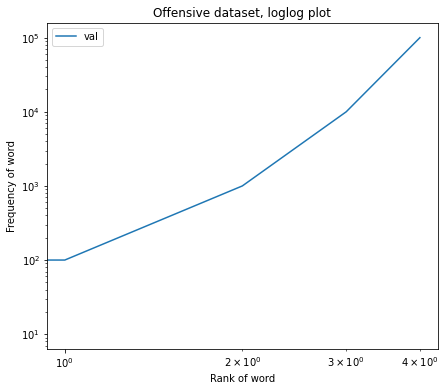

In [3]:
import matplotlib.pyplot as plt

# Creating x and y values for plot
y1 = [10,100,1000, 10000,100000]
x1 = [i for i in range(0,len(y1))]
#y2 = freq_words_train.values()
#x2 = [i for i in range(0,len(y2))]
#y3 = freq_words_test.values()
#x3 = [i for i in range(0,len(y3))]

plt.figure(figsize = (7,6))
plt.loglog(x1, y1, label="val")
#plt.loglog(x2, y2, label="train")
#plt.loglog(x3, y3, label="test")

plt.xlabel("Rank of word")
plt.ylabel("Frequency of word")
plt.title("Offensive dataset, loglog plot")

plt.legend()
plt.show()

# Usage of TweetEval and Twitter-specific RoBERTa models

In this notebook we show how to perform tasks such as masked language modeling, computing tweet similarity or tweet classificationo using our Twitter-specific RoBERTa models.

- Paper: [_TweetEval_ benchmark (Findings of EMNLP 2020)](https://arxiv.org/pdf/2010.12421.pdf)
- Authors: Francesco Barbieri, Jose Camacho-Collados, Luis Espinosa-Anke and Leonardo Neves.
- [Github](https://github.com/cardiffnlp/tweeteval)


## Preliminaries

We define a function to normalize a tweet to the format we used for TweetEval. Note that preprocessing is minimal (replacing user names by `@user` and links by `http`).

In [1]:
def preprocess(text):
    new_text = []
    for t in text.split(" "):
        t = '@user' if t.startswith('@') and len(t) > 1 else t
        t = 'http' if t.startswith('http') else t
        new_text.append(t)
    return " ".join(new_text)

We only need to install one dependnecy: the `transformers` library.

In [ ]:
# Run this in Terminal
#!conda install pytorch torchvision torchaudio -c pytorch

In [2]:
#!pip install transformers
#!pip install torch torchvision torchaudio

## Computing Tweet Similarity

In [3]:
from transformers import AutoTokenizer, AutoModel, TFAutoModel
import numpy as np
from scipy.spatial.distance import cosine
from collections import defaultdict

MODEL = "cardiffnlp/twitter-roberta-base"

tokenizer = AutoTokenizer.from_pretrained(MODEL)
model = AutoModel.from_pretrained(MODEL)

def get_embedding(text):
  text = preprocess(text)
  encoded_input = tokenizer(text, return_tensors='pt')
  features = model(**encoded_input)
  features = features[0].detach().cpu().numpy() 
  features_mean = np.mean(features[0], axis=0) 
  return features_mean

query = "The book was awesome"

tweets = ["I just ordered fried chicken 🐣", 
          "The movie was great", 
          "What time is the next game?", 
          "Just finished reading 'Embeddings in NLP'"]

d = defaultdict(int)
for tweet in tweets:
  sim = 1-cosine(get_embedding(query),get_embedding(tweet))
  d[tweet] = sim

print('Most similar to: ',query)
print('----------------------------------------')
for idx,x in enumerate(sorted(d.items(), key=lambda x:x[1], reverse=True)):
  print(idx+1,x[0])


Most similar to:  The book was awesome
----------------------------------------
1 The movie was great
2 Just finished reading 'Embeddings in NLP'
3 I just ordered fried chicken 🐣
4 What time is the next game?


## Feature Extraction

In [5]:
from transformers import AutoTokenizer, AutoModel, TFAutoModel
import numpy as np

MODEL = "cardiffnlp/twitter-roberta-base"
text = "Good night 😊"
text = preprocess(text)
tokenizer = AutoTokenizer.from_pretrained(MODEL)

# Pytorch
encoded_input = tokenizer(text, return_tensors='pt')
model = AutoModel.from_pretrained(MODEL)
features = model(**encoded_input)
features = features[0].detach().cpu().numpy() 
features_mean = np.mean(features[0], axis=0) 
#features_max = np.max(features[0], axis=0)

# # Tensorflow
# encoded_input = tokenizer(text, return_tensors='tf')
# model = TFAutoModel.from_pretrained(MODEL)
# features = model(encoded_input)
# features = features[0].numpy()
# features_mean = np.mean(features[0], axis=0) 
# #features_max = np.max(features[0], axis=0)

features_mean.shape

(768,)

## Masked language modeling

Use Twitter-RoBERTA-base to predict words in context using the `fill-mask` pipeline in `transformers`.

In [6]:
from transformers import pipeline, AutoTokenizer
import numpy as np

MODEL = "cardiffnlp/twitter-roberta-base"
fill_mask = pipeline("fill-mask", model=MODEL, tokenizer=MODEL)
tokenizer = AutoTokenizer.from_pretrained(MODEL)

def print_candidates():
    for i in range(5):
        token = tokenizer.decode(candidates[i]['token'])
        score = np.round(candidates[i]['score'], 4)
        print(f"{i+1}) {token} {score}")

texts = [
 "I am so <mask> 😊",
 "I am so <mask> 😢" 
]
for text in texts:
    t = preprocess(text)
    print(f"{'-'*30}\n{t}")
    candidates = fill_mask(t)
    print_candidates()

------------------------------
I am so <mask> 😊
1)  happy 0.402
2)  excited 0.1441
3)  proud 0.143
4)  grateful 0.0669
5)  blessed 0.0334
------------------------------
I am so <mask> 😢
1)  sad 0.2641
2)  sorry 0.1605
3)  tired 0.138
4)  sick 0.0278
5)  hungry 0.0232


## Use TweetEval Classifiers

We currently provide the following fine-tuned models for different tweet classification tasks:

- emoji prediction (`emoji`)
- emotion detection (`emotion`)
- hate speech detection (`hate`)
- irony detection (`irony`)
- offensive language identification (`offensive`)
- sentiment analysis (`sentiment`)
- _(coming soon)_ stance detection (`stance`) with 5 targets (`abortion`, `atheism`, `climate`, `feminist`, `hillary`), for example: `stance-abortion`


In [7]:
from transformers import AutoModelForSequenceClassification
from transformers import TFAutoModelForSequenceClassification
from transformers import AutoTokenizer
import numpy as np
from scipy.special import softmax
import csv
import urllib.request

task='emotion'
MODEL = f"cardiffnlp/twitter-roberta-base-{task}"

tokenizer = AutoTokenizer.from_pretrained(MODEL)

In [8]:
# download label mapping
mapping_link = f"https://raw.githubusercontent.com/cardiffnlp/tweeteval/main/datasets/{task}/mapping.txt"
with urllib.request.urlopen(mapping_link) as f:
    html = f.read().decode('utf-8').split("\n")
    csvreader = csv.reader(html, delimiter='\t')
labels = [row[1] for row in csvreader if len(row) > 1]

In [9]:
# PT
model = AutoModelForSequenceClassification.from_pretrained(MODEL)

text = "Good night 😊"
text = preprocess(text)
encoded_input = tokenizer(text, return_tensors='pt')
output = model(**encoded_input)
scores = output[0][0].detach().numpy()
scores = softmax(scores)

# # TF
# model = TFAutoModelForSequenceClassification.from_pretrained(MODEL)

# text = "Good night 😊"
# encoded_input = tokenizer(text, return_tensors='tf')
# output = model(encoded_input)
# scores = output[0][0].numpy()
# scores = softmax(scores)

In [10]:
ranking = np.argsort(scores)
ranking = ranking[::-1]
for i in range(scores.shape[0]):
    l = labels[ranking[i]]
    s = scores[ranking[i]]
    print(f"{i+1}) {l} {np.round(float(s), 4)}")

1) joy 0.9061
2) optimism 0.0407
3) sadness 0.0406
4) anger 0.0126
